# EKF Localizaton
## Done by: Abhinav and Projit

Implementing and applying an Extended Kalman Filter (EKF) to estimate the 2D pose of the robot throughout its traversal using sensor measurements. There are two sensors, namely a wheel odometer that measures the translational and rotational speed and the laser rangefinder, that gives us the range and bearing to the landmarks. There are 17 landmarks in total in the robot's environment. 

### This is a localization problem, and not SLAM
The motion model and sensor model are non linear, and hence we use an EKF instead of a Kalman Filter. But note that we solve the problem of localization only, and not the problem of SLAM. In SLAM we simultaneuosly estimate the position of the robot and estimate the map of its environment. However, we already know the positions of the landmarks and hence, we only have to do the localization bit. 

### Acknowledgements
Special thanks to Prof. Cyrill Stachniss for his awesome lecture on EKF and EKF-SLAM, to Prof. Tim Barfoot for the dataset and to Karnik, for helping us debug our code. 

Let's get started then!

As usual, we first import the required libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt

We then load the dataset, that has been provided to us in the form of a numpy archive file. To see the variables it contains, refer to the readme file, which also contains an accurate description of the problem. To access each invidual array, we simply do `dataset['array_name']`

In [27]:
dataset = np.load('dataset.npz')

## Different functions for each step of the EKF algorithm

- Here are functions for each step of the algorithm.

### Predicting Mean : 
The motion model is given by: Mu(t) = g( u(t), mu(t-1) ) 

In [28]:
def predict_M(Ut, Mt_1):
    dt = 0.1
    x1 = Mt_1[0][0]
    y1 = Mt_1[1][0]
    theta1 = Mt_1[2][0]
    
    vk = Ut[0][0]
    wk = Ut[1][0]
    
    mat1 = np.array([[x1], [y1], [theta1]])
    mat2 = np.array([[np.cos(theta1), 0], [np.sin(theta1), 0], [0, 1]])
    mat3 = np.array([[vk], [wk]])
    
    return mat1 + dt * mat2 @ mat3 

### Computing Jacobian 'G' of the motion model g()

In [29]:
def jacobian(Ut, Mt):
    dt = 0.1
    xk = Mt[0][0]
    yk = Mt[1][0]
    thetak = Mt[2][0]
    
    vk = Ut[0][0]
    wk = Ut[1][0]
    
    term1 = (-1) * vk * dt * np.sin(thetak)
    term2 = vk * dt * np.cos(thetak)
    
    G = [[1,0,term1], [0,1,term2], [0,0,1]]
    return np.array(G)

### Predicting Covariance 

In [30]:
def predict_Sig(Sigt_1, Mt, Rt, Ut):
    Gt = jacobian(Ut, Mt)
    return Gt @ Sigt_1 @ Gt.T + Rt

### The prediction steps in the EKF Algorithm:

In [31]:
def prediction(Ut, Mt_1, Sigt_1, Rt):
    Mt = predict_M(Ut, Mt_1)
    Sigt = predict_Sig(Sigt_1, Mt, Rt, Ut)
    return Mt, Sigt

## Correction
- Now we apply correction, that is, whether we trust our prediction or the sensor observation. 
- We do so by computing the weighted mean between the two. 

### Computing the Jacobian 'H' of h() - the sensor model 

In [32]:
def jacobian_2(Mt, landmark, d):
    xl = landmark[0][0]
    yl = landmark[1][0]
    xk = Mt[0][0]
    yk = Mt[1][0]
    thetak = Mt[2][0]

    p = xl - xk - d * np.cos(thetak)
    q = yl - yk - d * np.sin(thetak)
    
    normpq = np.sqrt(p*p + q*q)
    pq = (p*p + q*q)
    
    val1 = -p / normpq
    val2 = -q / normpq
    val3 = (d / normpq) * (p * np.sin(thetak) - q * np.cos(thetak))
    val4 = q / pq
    val5 = -p / pq
    val6 = ( -d * (p * np.cos(thetak) + q * np.sin(thetak)) / pq ) - 1
    
    G = np.array([[val1, val2, val3], [val4, val5, val6]])
    return G

### Computing the Kalman Gain

In [33]:
def get_K(Sigt, Mt, landmark, Qt, d):
    Ht = jacobian_2(Mt, landmark, d) 
    K = Sigt @ Ht.T @ np.linalg.inv(Ht @ Sigt @ Ht.T + Qt)
    return K, Ht

### Correcting the Mu and Sigma values

After having calulated the Jacobian and Kalman Gain, we now apply the correction steps of the EKF algorithm. 

- This function normalises the angles, that the laser rangefinder estimates for each landmark. 

In [34]:
def change_range(x):
    return (x + np.pi) % ( 2 * np.pi ) - np.pi

- This computes the distance and bearing to each landmark, in accordance with the non linear model. 

In [35]:
def sensor_model(Mt, landmark, d, num):
    xl = landmark[0][0]
    yl = landmark[1][0]
    xk = Mt[0][0]
    yk = Mt[1][0]
    thetak = Mt[2][0]
    
    p = xl - xk - d * np.cos(thetak)
    q = yl - yk - d * np.sin(thetak)
        
    val1 = np.sqrt(p*p + q*q)
    val2 = np.arctan2(q, p) - thetak
    val2_modified = change_range(val2)
    
    
    return np.array([[val1], [val2_modified]])

- Applying correction to the mean. Mt is the mean we predicted after the first step of the algorithm. 
- Now depending on value of Kalman Gain, we compute the corrected mean. 

In [36]:
def update_M(Mt, Kt, Zt, landmark, d):
    h_M = sensor_model(Mt, landmark, d, Zt[1])
    M = Mt + Kt @ (Zt - h_M)
    return M
    

Similarly, this function applies correction to the covariance 'sigma'

In [37]:
def update_sig(Sigt, Kt, Ht):
    I = np.eye(3)
    S = (I - (Kt @ Ht)) @ Sigt
    return S

### Correction steps in the EKF algorithm
This function calls the appropriate functions, thereby implementing the next 3 steps of the EKF algorithm, after prediction

In [38]:
def correction(Sigt, Mt, landmark, Qt, Zt, d):
    Kt, Ht = get_K(Sigt, Mt, landmark, Qt, d)
    Mt = update_M(Mt, Kt, Zt, landmark, d)
    Sigt = update_sig(Sigt, Kt, Ht)
    return Kt, Ht, Mt, Sigt

## Loading the data

- So we have implemented all the functions that would be necessary for the algorithm. 
- Now we initialize the values, load the data from the data set so that we can call the functions in accordance with the EKF algorithm!

- We initialise initial mean with the groundtruth pose of the robot at time t=0 
- We take variance as diag{1,1,0,1}.

In [39]:
M0 = np.array([[dataset['x_true'][0][0]], [dataset['y_true'][0][0]], [dataset['th_true'][0][0]]])
Sig0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0.1]])

- Then we initialize Rt, the noise matrix, as a 3x3 matrix with the variances in v and w. 
- And we intitialize Qt as a 2x2 noise matrix with the variances in r and b.

In [40]:
Rt = np.array([[dataset['v_var'][0][0], 0, 0], [0, dataset['v_var'][0][0], 0], [0, 0, dataset['om_var'][0][0]]])
Qt = np.array([[dataset['r_var'][0][0], 0], [0, dataset['b_var'][0][0]]])

Our laser rangefinder measures two values: the distance to the landmark 'r' and the bearing angle 'b' and our wheel odometer measures the translational velocity 'v' and rotational velocity 'w' of the robot. We load them. 

In [85]:
r = dataset['r'] 
b = dataset['b'] 
Uv = dataset['v']
Uom = dataset['om']

- Similarly, we load all the landmarks. For each time stamp, we store the wheel odometer readings (v,w) in 'U'. 
- We have two arrays: Mt and Sigt, which will store the pose of the robot for every time stamp. 
- So after running the entire EKF algorithm, these array must move up to a size of 12609x1, each value representing the pose at each second

In [86]:
landmarks = dataset['l']

U = []
for i in range(len(dataset['v'])):
    U.append(np.array( [ [Uv[i][0]], [Uom[i][0]] ] ))
U = np.array(U)

time_stamps = len(dataset['t'])
d = dataset['d'][0][0]

Mt = []
Sigt = []
Mt.append(M0)
Sigt.append(Sig0)

## Running the EKF algorithm
- Now we run the algorithm for all the timestamps
- For each iteration of the loop, we compute the prediction and then, the correction - EKF algorithm in a nutshell.  
- The prediction and correction functions are called, which in turn call the other appropriate functions and all the steps of the algorithm are thus implemented. 
- Note that for each timestamp, though we consider the wheel odometer measurement, we do NOT consider all the laser rangefinder measurement. 
- This is simply becasue the rangefinder gives us a zero value for some landmarks, so we neglect those.

In [87]:
for i in range(time_stamps):
    #print("Timestamp: {}".format(i))
    Mt_new, Sigt_new = prediction(U[i], Mt[i], Sigt[i], Rt)

    for index, landmark in enumerate(landmarks):
        Zt = np.array( [ [r[i][index]], [b[i][index]] ] )
        lm = np.array( [ [landmark[0]], [landmark[1]] ] )
        if(Zt[0] == 0):
            continue

        Kt_c, Ht_c, Mt_new, Sigt_new = correction(Sigt_new, Mt_new, lm, Qt, Zt, d)
    
    Mt.append(Mt_new)
    Sigt.append(Sigt_new)

## Voila!

- And yup, that's it! We have successfully implemented all the steps of the EKF algorithm, for each timestamp!
- At the end of each iteration, we update our arrays Mt and Sigt to store the pose of the robot. 
- So we have the pose of the robot for each second, upto 12609 seconds! 

Let's plot this and check it out!

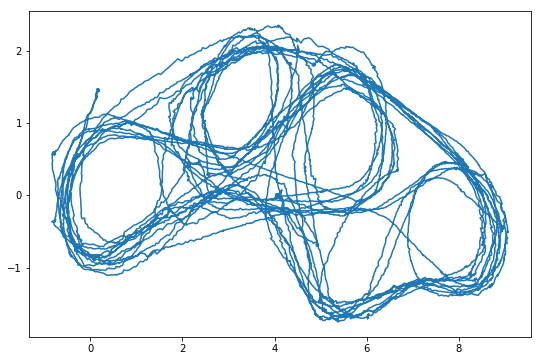

In [88]:
x = []
y = []

for m in np.array(Mt):
    x.append(m[0][0])
    y.append(m[1][0])

plt.figure(figsize = (9,6))
plt.plot(x, y)

- So that's our predicted path. We predict the trajectory of the robot would look something like this ^
- But how do we know if this is the correct one?

## Ground Truth Trajectory 

- Thanks to Karnik, we also have the ground truth trajectory! So let's plot that along with our estimate and visualise the difference. 
- The red one is the ground truth, and the one in cyan is our EKF estimate

In [89]:
def plot():
    plt.figure(figsize = (9,6))
    plt.plot(X_ground, Y_ground, c='r')
    plt.plot(x,y,c='c')
    plt.show()

In [90]:
X_ground = dataset['x_true']
Y_ground = dataset['y_true']

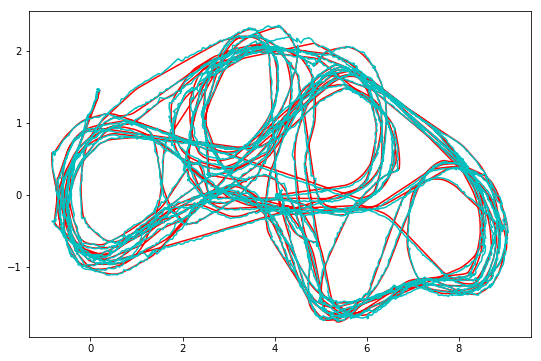

In [91]:
plot()

### PRETTY COOL HUH! ^

## What if we used only wheel odometer measurements?

- We used the measurements from the wheel odometer, which helped in the prediction of our estimate. 
- And then we used the laser rangefinder sensor measurements to apply correction, with kalman gain and computing the weighted mean. 

But what if we didn't use the sensor measurements? Would the wheel odometer values have sufficed? \
- Let's check it out. For this, we simply **eliminate the correction step** of the algorithm. 
- So we only predict and do not take the sensor values into consideration.

In [92]:
Mt = []
Sigt = []
Mt.append(M0)
Sigt.append(Sig0)

for i in range(time_stamps):
    Mt_new, Sigt_new = prediction(U[i], Mt[i], Sigt[i], Rt)
    Mt.append(Mt_new)
    Sigt.append(Sigt_new)

- Now let's plot this too in conjunction with the ground truth trajectory. 
- Again, the ground truth trajectory is in red, and the on in cyan is ours.

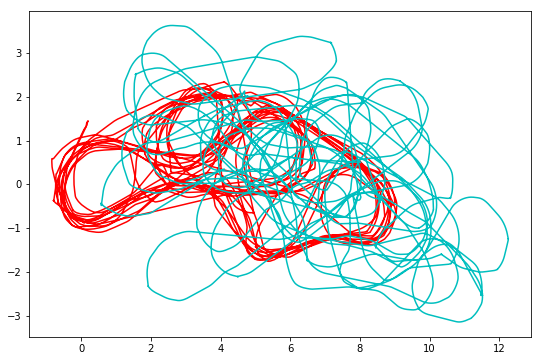

In [93]:
x = []
y = []

for m in np.array(Mt):
    x.append(m[0][0])
    y.append(m[1][0])
    
plot()

### Really bad compared to the previous one :( 

- So yes, the correction step in the EKF algorithm is paramount. 
- We can't rely solely on wheel odometer measurements. 
- By considering sensor values and computing the weighted mean between prediction and covariance, we get a better estimate of our pose. 

### Testing 
- Just checking whether the matrices we compute have the correct dimensions and printing values out, for our convenience.
- Helps in debugging :)

In [97]:
def test_shapes_motion_model():
    Mt_1 = np.array([[3], [2], [1]])
    Ut = np.array([[2], [3]])
    print("[Predict_M] Input shapes: Ut: {}, Mt_1: {}".format(Ut.shape, Mt_1.shape))
    output = predict_M(Ut, Mt_1)
    print("[Predict_M] Output shape: {}".format(output.shape))

In [98]:
def test_prediction():
    Mt_1 = np.array([[3], [2], [1]])
    Ut = np.array([[2], [3]])
    Rt = np.array([[5, 0, 0], [0, 2, 0], [0, 0, 3]])
    Sigt_1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    print("[Prediction] Input Shapes: Ut: {}, Mt_1: {}, Sigt_1: {}, Rt: {}". format(Ut.shape, Mt_1.shape, Sigt_1.shape, Rt.shape))
    Mt, Sigt = prediction(Ut, Mt_1, Sigt_1, Rt)
    print("[Prediction] Final Shape of Mt: {}".format(Mt.shape))
    print("[Prediction] Final Shape of Sigt: {}".format(Sigt.shape))

In [99]:
def test_correction():
    Sigt = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    Mt = np.array([[3], [2], [1]])
    landmark = np.array([[2], [1]])
    
    Qt = np.array([[2, 4], [3, 2]])
    Zt = np.array([[3], [4]])
    d = dataset['d'][0][0]
    Kt, Ht, Mt, Sigt = correction(Sigt, Mt, landmark, Qt, Zt, d)
    print(Kt)
    print("[Correction] Input Shapes: Sigt: {}, Mt: {}, landmark: {}, Qt: {}, Zt: {}, rounded d val: {}".format(Sigt.shape, Mt.shape, landmark.shape, Qt.shape, Zt.shape, np.round(d, 2)))
    print("[Correction] Final Shapes: Kt: {}, Ht: {}, Mt: {}, Sigt: {}".format(Kt.shape, Ht.shape, Mt.shape, Sigt.shape))

In [102]:
def test(Mt, landmark, d):
    print("Mu t: \n", Mt)
    print("landmark: \n", landmark)
    print("D value: \n ", d)

In [103]:
test_prediction()
test_shapes_motion_model()
test_correction()

print("Shape of Mu0: {}".format(M0.shape))
print("Sig0 shape: {},\n {}".format(Sig0.shape, Sig0))
print("Shape of Rt: {}, \n {}".format(Rt.shape, Rt))
print("Shape of Qt: {}, \n {}".format(Qt.shape, Qt))
print("Shape of U: {}".format(U.shape))

print(np.array(Mt)[0][0])
print(np.array(Mt)[0][0][0])

[Prediction] Input Shapes: Ut: (2, 1), Mt_1: (3, 1), Sigt_1: (3, 3), Rt: (3, 3)
[Prediction] Final Shape of Mt: (3, 1)
[Prediction] Final Shape of Sigt: (3, 3)
[Predict_M] Input shapes: Ut: (2, 1), Mt_1: (3, 1)
[Predict_M] Output shape: (3, 1)
[[ 0.11088147 -0.28339465]
 [ 0.4836765  -0.60310182]
 [ 0.85647153 -0.92280899]]
[Correction] Input Shapes: Sigt: (3, 3), Mt: (3, 1), landmark: (2, 1), Qt: (2, 2), Zt: (2, 1), rounded d val: 0.22
[Correction] Final Shapes: Kt: (3, 2), Ht: (2, 3), Mt: (3, 1), Sigt: (3, 3)
Shape of Mu0: (3, 1)
Sig0 shape: (3, 3),
 [[1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  0.1]]
Shape of Rt: (3, 3), 
 [[0.00442026 0.         0.        ]
 [0.         0.00442026 0.        ]
 [0.         0.         0.00818609]]
Shape of Qt: (2, 2), 
 [[0.00090036 0.        ]
 [0.         0.00067143]]
Shape of U: (12609, 2, 1)
[3.01975613]
3.019756132877692
